In [5]:
import torch
import numpy as np
%load_ext autoreload
%autoreload 2
from utils1 import load_data,default_loader,trainset,imshow,normal,layershow
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torchsummary import summary
import time,datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Data Path**

In [6]:
!pip install torchsummary

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
datapath = "./datasets"
data,paths,labels = load_data(datapath)
available_field = ['url','videoname','locs','frameids','label_names','crop','scale','origRes','isYouTubeSubset']


**shift the data**

In [8]:
num_data=len(paths)
index=np.arange(num_data)
np.random.shuffle(index)
paths=[paths[i] for i in index]
labels=[labels[i] for i in index]

**partition of the data into three part**

In [9]:
#how many data we will put into each set
train_num,val_num, test_num  = int(0.7*num_data),int(num_data*0.1),int(num_data*0.2)
new_w,new_h=224,224

assert(train_num+val_num+test_num<=num_data)
train_path,train_label=paths[0:train_num],labels[0:train_num]
val_path,  val_label  =paths[train_num:train_num+val_num],labels[train_num:train_num+val_num]
test_path, test_label =paths[train_num+val_num:],labels[train_num+val_num:]
bc=8

train_data  = trainset(train_path,train_label,new_w,new_h)
trainloader = DataLoader(train_data, batch_size=bc,shuffle=True)

val_data  = trainset(val_path,val_label,new_w,new_h)
valloader = DataLoader(val_data, batch_size=bc,shuffle=True)

test_data  = trainset(test_path,test_label,new_w,new_h)
testloader = DataLoader(test_data, batch_size=bc,shuffle=True)
print("number of data in the training set    :", len(train_data))
print("number of data in the validation set  :", len(val_data))
print("number of data in the test set        :", len(test_data))

number of data in the training set    : 3500
number of data in the validation set  : 500
number of data in the test set        : 1000


**load example data from test set**

In [10]:
count = 1
for data in testloader:
    if count == 1:
        inputs_try,labels_try = data
    count +=1
print(count,"batches")   
print(inputs_try.shape)
print(labels_try.shape)

126 batches
torch.Size([8, 3, 224, 224])
torch.Size([8, 7, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


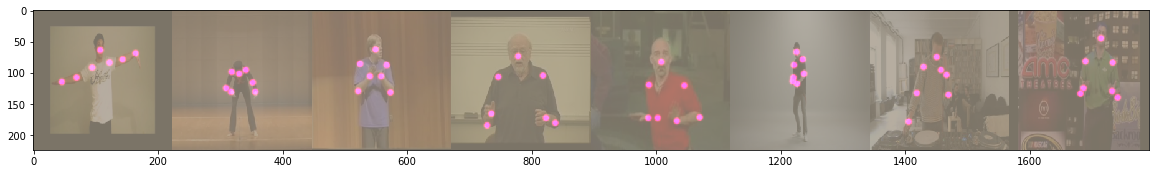

In [11]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,[224,224],labels_try) 

In [12]:
use_gpu=torch.cuda.is_available()
use_gpu

True

In [13]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            #nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),  
            
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            
            
            nn.Conv2d(64, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=0.25),
            
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=0.25),
            
            
            nn.Conv2d(256, 512, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, stride=2),
            
        )
        self.drop1=nn.Dropout(p=0.5)
        #self.fn1=nn.Linear(512*5*5,7)
        self.fn1=nn.Linear(1024,7)
    def forward(self, x):
        #x=self.seq(x)
        x=x.view(-1,2,1024)
        #x=self.drop1(x)
        x=self.fn1(x)
        x=x.reshape(-1,7,2)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Regressor().to(device)
#summary(model, (3, 180, 320))

In [15]:
model_res = torchvision.models.resnet152(pretrained=True )

In [16]:
model_res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [17]:
model_res.fc = Regressor()

In [18]:
def train(model,trainloader,loss_fn,optimizer):
    if use_gpu:
        model=model.to("cuda")
        
    model.train(True)
    optimizer = optimizer

    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    for data in trainloader:
        inputs, labels = data
        bs = labels.size(0)

        if use_gpu:
            inputs=inputs.cuda()
            labels=labels.cuda()


        outputs = model(inputs)
        #print(outputs.shape, labels.shape)
        loss = loss_fn(outputs,labels) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #running_loss+=loss.data.item()
        #_,preds = torch.max(outputs.data,1)
        preds=outputs.data
        # statistics
        running_loss += loss.data.item()
        #print(preds.shape,labels.shape)
        #running_corrects += torch.sum(preds == labels)

        if(size%int(len(trainloader)/20)==0 and size!=0):
            print(running_loss / size, size)
        size += bs
              
            
    epoch_loss = running_loss / size

    #acc_train[epoch_num] = epoch_acc
    #print( 'Train - Loss: {:.4f}'.format(epoch_loss))
        
    return epoch_loss


In [19]:
def test(model,data_loader,loss_fn,optimizer):
    model.eval()
    if use_gpu:
        model=model.to("cuda")
    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    with torch.no_grad():

        for data in data_loader:
            inputs, labels = data    
            bs = labels.size(0)

            if use_gpu:
                inputs=inputs.cuda()
                labels=labels.cuda()

            outputs = model(inputs)
            loss = loss_fn(outputs,labels) 

            #running_loss+=loss.data.item()
            #_,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            #running_corrects += torch.sum(preds == labels)
            size += bs
        out = torchvision.utils.make_grid(inputs.cpu(),padding=0)
        imshow(out,[224,224],outputs.cpu())
        epoch_loss = running_loss / size
    return epoch_loss

In [20]:
pose_detection = model_res
# choose the appropriate loss
loss_fn = nn.MSELoss(reduction='mean')
#loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1.0
# your SGD optimizer
#optimizer_cl = torch.optim.Adadelta(pose_detection.parameters(),lr = learning_rate)

parameters = []
parameters.append({ "params": pose_detection.fc.parameters()})


optimizer = torch.optim.Adadelta(parameters,lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# and train for 10 epochs
l_t,l_v=[],[]

1329.9349481491815 168
1026.806631905692 336
822.3063000875806 504
681.0853691101074 672
584.9261968703497 840
517.0972785949707 1008
466.11516150649715 1176
427.67441922142393 1344
397.2971006524626 1512
372.35216707502093 1680
350.22447766060435 1848
333.1314010922871 2016
317.5026153732132 2184
304.40675125641076 2352
292.5808254181393 2520
282.5340171768552 2688
273.65544867849485 2856
265.37029114980544 3024
257.0206735462772 3192
249.2607484272548 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


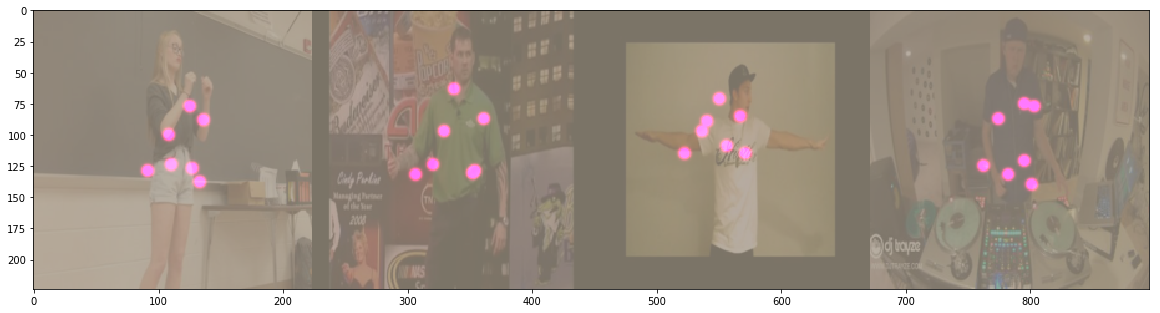

Epoch: 1  Train - Loss: 243.25 ; Validation - Loss: 110.65
Time consumed: 0:01:04.086011 Remaining time: 0:09:36.774098
105.2576786222912 168
101.25114150274368 336
102.91434260777065 504
104.6769962310791 672
103.19320929391044 840
102.95310344393292 1008
101.57937837457982 1176
100.60223801930745 1344
99.79147895934089 1512
98.61701545715331 1680
97.41817664274406 1848
97.1025413785662 2016
95.77155415741079 2184
95.08585109840445 2352
95.00635545518664 2520
94.35465480032421 2688
93.72295248207925 2856
93.10708442566887 3024
92.2035584700735 3192
92.04298284621466 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


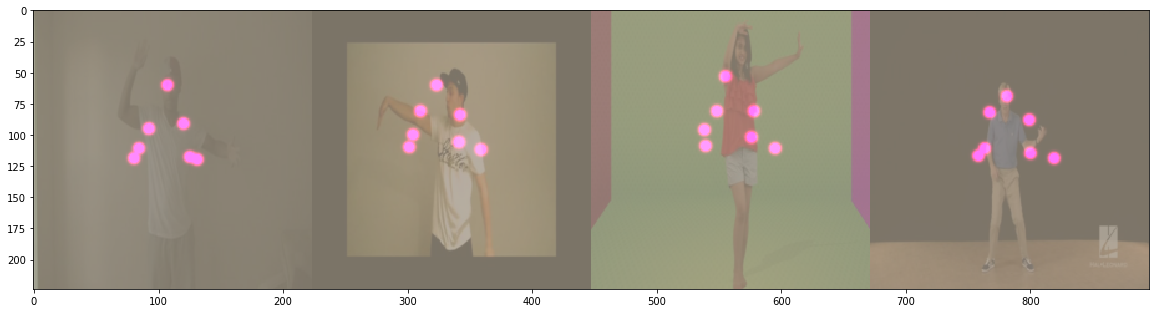

Epoch: 2  Train - Loss: 91.68 ; Validation - Loss: 83.65
Time consumed: 0:02:08.095296 Remaining time: 0:08:32.381183
88.64551162719727 168
83.25962429954892 336
83.50047665550595 504
82.56486815497989 672
81.48057665143695 840
81.57365054175968 1008
79.88343801952544 1176
80.428410473324 1344
79.63291058212361 1512
79.08263134729295 1680
78.52312480216419 1848
77.98060481510466 2016
77.85665576361912 2184
77.72536853868134 2352
77.30206919473315 2520
76.60929942698706 2688
76.42738741385837 2856
76.33240774951915 3024
76.09528402935592 3192
76.06263824190412 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


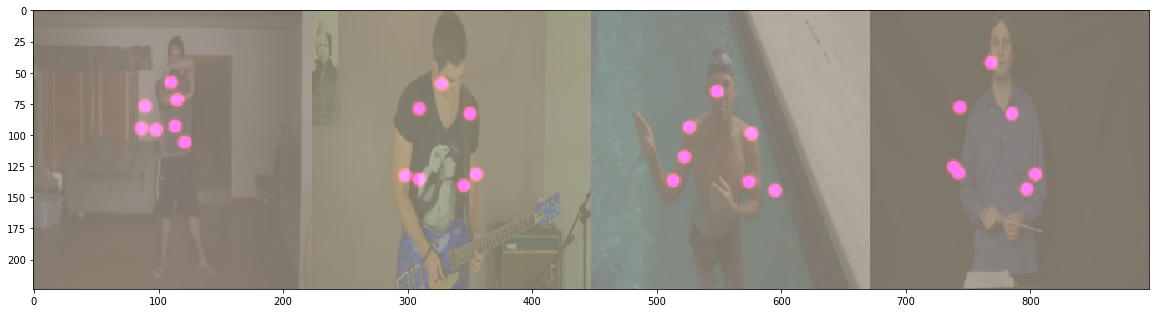

Epoch: 3  Train - Loss: 75.68 ; Validation - Loss: 73.61
Time consumed: 0:03:11.867297 Remaining time: 0:07:27.690361
71.74369666689918 168
67.47200929550897 336
68.03728715200273 504
71.42020797729492 672
71.05515154883975 840
70.5597675868443 1008
72.04774316800695 1176
71.26830915042332 1344
70.86326678846248 1512
71.12659475235712 1680
71.46573750384442 1848
71.60562316198198 2016
71.21374812842289 2184
70.39486216850021 2352
69.45241920228989 2520
69.7027837719236 2688
69.72704739931251 2856
69.75971102336096 3024
69.57619788473411 3192
69.379176902771 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


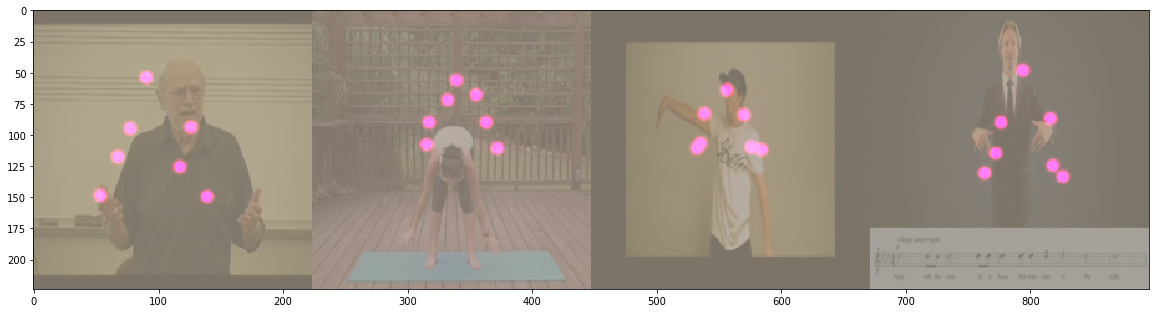

Epoch: 4  Train - Loss: 69.10 ; Validation - Loss: 67.66
Time consumed: 0:04:16.192518 Remaining time: 0:06:24.288778
71.63261885870071 168
66.4020040602911 336
67.01163482666016 504
66.81817399887811 672
67.65926557268415 840
67.23934450603667 1008
66.4404884909286 1176
66.00193686712356 1344
66.08728821567757 1512
66.01265732901437 1680
66.29864247639973 1848
65.7949426741827 2016
66.25438679006947 2184
66.20701993565982 2352
65.73983730740018 2520
65.74726365861439 2688
65.8701454397677 2856
65.62987016243909 3024
65.18584778195336 3192
64.89808748790196 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


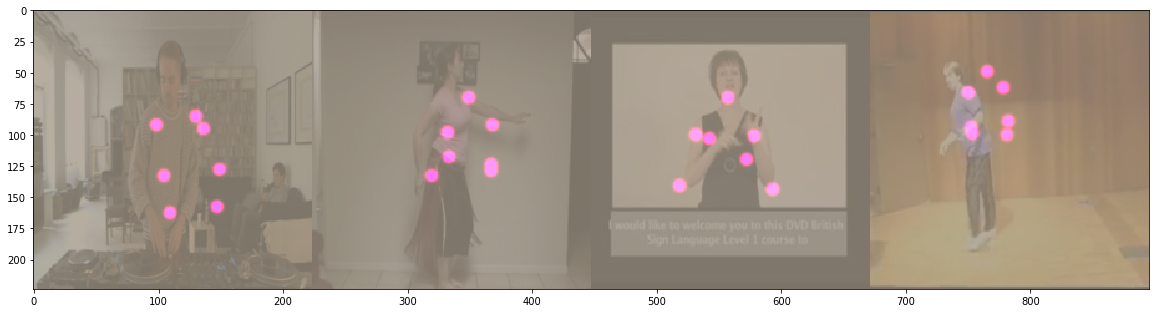

Epoch: 5  Train - Loss: 64.49 ; Validation - Loss: 63.36
Time consumed: 0:05:20.465354 Remaining time: 0:05:20.465354
58.67011597042992 168
58.70167100997198 336
57.009824510604616 504
59.75893685931251 672
60.28459894089472 840
60.934325869121245 1008
61.01149344930843 1176
61.24615019843692 1344
60.721434214758496 1512
60.95477904365176 1680
60.610234124319895 1848
60.47104552435496 2016
60.84839894221379 2184
61.24811294451863 2352
61.230562137422105 2520
61.012151735169546 2688
61.45755962297028 2856
61.37353688699228 3024
61.185995388748054 3192
61.10572934831892 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


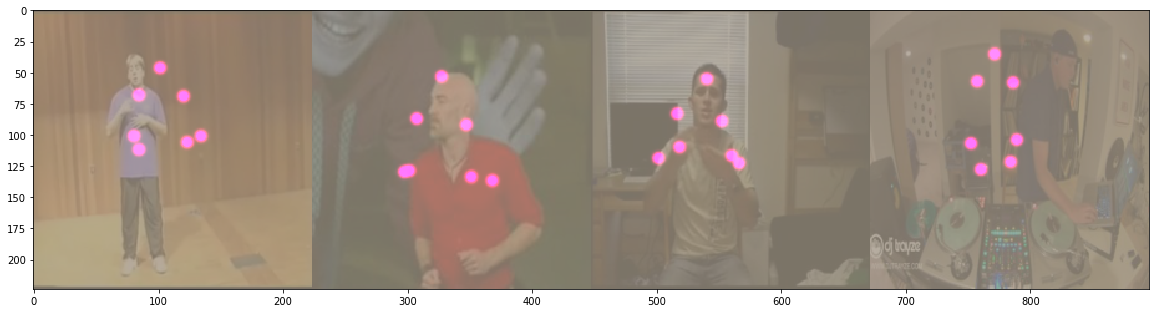

Epoch: 6  Train - Loss: 61.44 ; Validation - Loss: 62.66
Time consumed: 0:06:24.391851 Remaining time: 0:04:16.261234
58.496981666201634 168
60.21676063537598 336
60.14307860722617 504
60.903060981205535 672
60.75531974065871 840
60.56784266517276 1008
59.40377789451962 1176
59.572230180104576 1344
59.544387766923855 1512
60.085355767749604 1680
59.646011550705154 1848
60.1560940969558 2016
60.09456520639496 2184
60.045348407459905 2352
60.52911121428959 2520
60.33902697336106 2688
60.669498635941196 2856
60.46164476808417 3024
60.338701888732146 3192
60.58577614284697 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


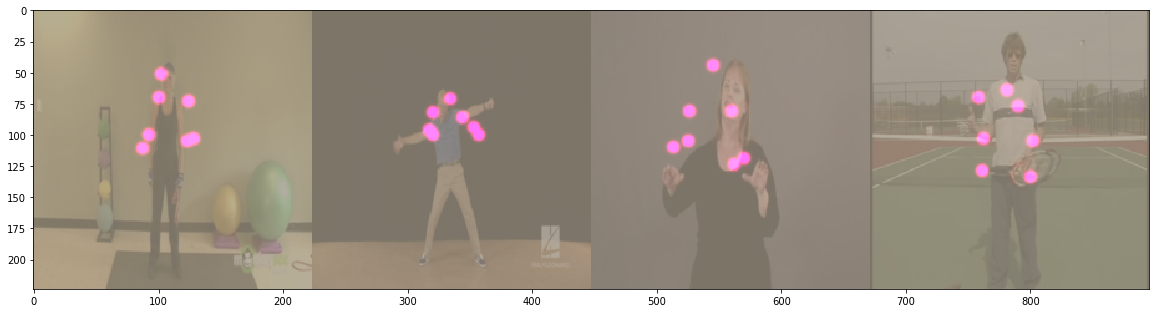

Epoch: 7  Train - Loss: 60.28 ; Validation - Loss: 60.86
Time consumed: 0:07:27.850291 Remaining time: 0:03:11.935839
63.09265381949289 168
60.36330663590204 336
58.86980507865785 504
58.918755554017565 672
59.28563303266253 840
58.184542655944824 1008
58.61408864235391 1176
59.520044587907336 1344
59.24842349057475 1512
59.76104746318999 1680
59.96130385956207 1848
60.530098430694096 2016
60.19005579127497 2184
59.97703030644631 2352
59.94043651156955 2520
59.77758185636429 2688
59.414500330008714 2856
59.30078264771315 3024
59.25695516352068 3192
59.22689012799944 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


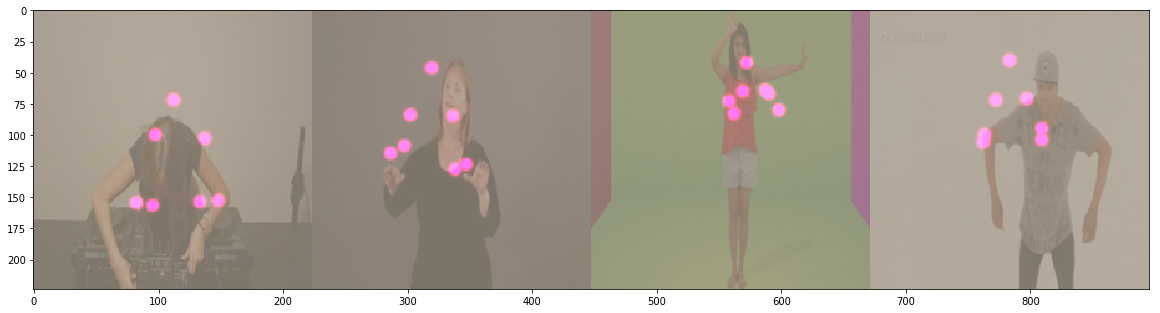

Epoch: 8  Train - Loss: 59.14 ; Validation - Loss: 60.00
Time consumed: 0:08:31.219192 Remaining time: 0:02:07.804798
60.46808170136951 168
65.6399020694551 336
61.05658419170077 504
58.89444512412662 672
58.33656748817081 840
59.058020985315714 1008
58.50856573403287 1176
58.73180976368132 1344
58.54025323050363 1512
58.3741004489717 1680
57.88496758101822 1848
58.00850495837984 2016
58.29007187867776 2184
57.801170251807385 2352
57.965619156852604 2520
57.39813441889627 2688
57.54138358834745 2856
57.77956033131433 3024
57.633030802982496 3192
57.94087122508458 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


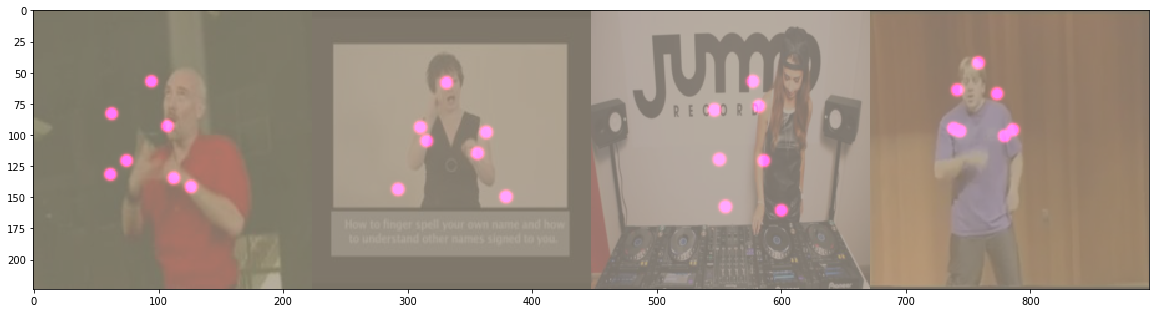

Epoch: 9  Train - Loss: 57.90 ; Validation - Loss: 58.13
Time consumed: 0:09:34.659039 Remaining time: 0:01:03.851004
57.8376711890811 168
56.17527929941813 336
56.108362652006605 504
54.50287264869327 672
56.231367783319385 840
57.1606745946975 1008
57.40353063985604 1176
57.40019407726469 1344
56.76692601360341 1512
56.451038215273904 1680
56.70664287748791 1848
56.23477533128526 2016
56.612991102449186 2184
56.53607784971899 2352
56.32997797405909 2520
56.682833478564305 2688
56.68875678781034 2856
56.95269843510219 3024
56.82854795336424 3192
57.39255081812541 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


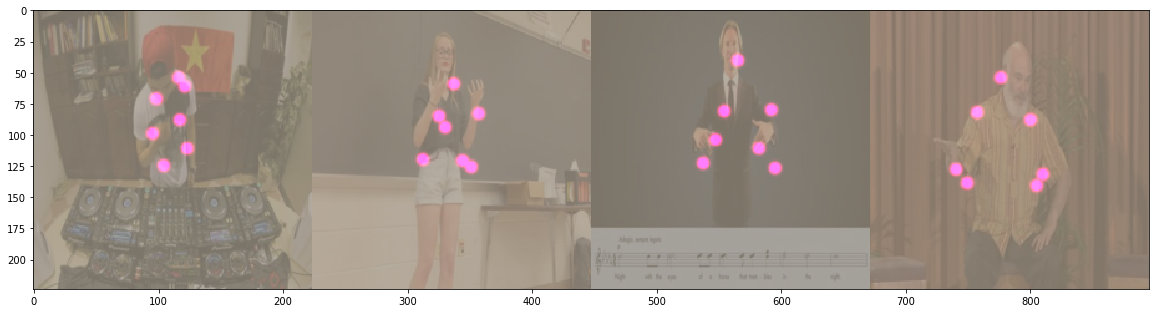

Epoch: 10  Train - Loss: 57.39 ; Validation - Loss: 57.58
Time consumed: 0:10:38.291005 Remaining time: 0:00:00


In [21]:
num_epoch=10

time_begin=time.time()

for epoch in range(num_epoch):
    scheduler.step()
    epoch_loss=train(pose_detection,trainloader,loss_fn,optimizer)
    val_loss  =test(pose_detection,valloader,loss_fn,optimizer)
    print('Epoch:',epoch+1, ' Train - Loss: {:.2f} ; Validation - Loss: {:.2f}'.format(epoch_loss,val_loss))
    l_t.append(epoch_loss)
    l_v.append(val_loss)
    now=time.time()
    time_used=now-time_begin
    time_remain= time_used /(epoch+1) *(num_epoch-1-epoch)
    print("Time consumed:", datetime.timedelta(seconds=time_used), "Remaining time:", datetime.timedelta(seconds=time_remain))
    
    

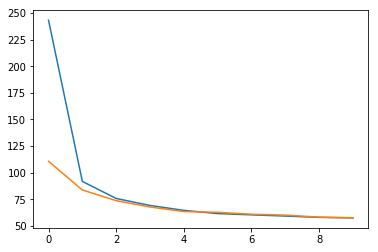

In [22]:
plt.plot(range(len(l_t)),l_t,l_v)

In [23]:
pose_detection.train(False)    
preds = pose_detection(inputs_try.cuda()).cpu()
print(preds.shape)
print(labels_try.shape)

torch.Size([8, 7, 2])
torch.Size([8, 7, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


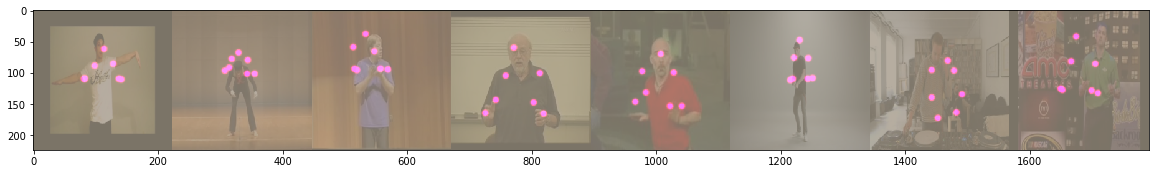

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


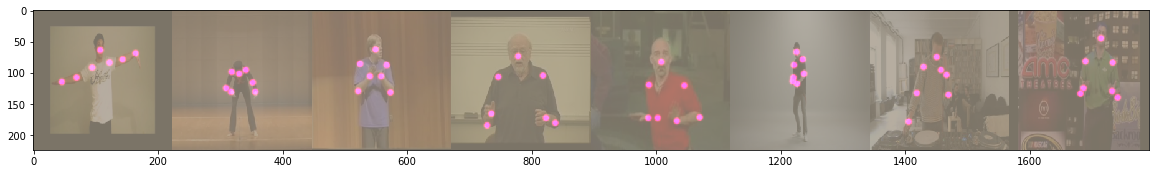

In [26]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,[224,224],preds) 
imshow(out,[224,224],labels_try)

In [ ]:
def train(model,trainloader,loss_fn,optimizer,n_epochs=10):
    if use_gpu:
        model=model.to("cuda")
        
    model.train(True)
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    optimizer = optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    for epoch_num in range(n_epochs):
        scheduler.step()
        running_corrects = 0.0
        running_loss = 0.0
        size = 0
        for data in trainloader:
            inputs, labels = data
            bs = labels.size(0)
            
            if use_gpu:
                inputs=inputs.cuda()
                labels=labels.cuda()
            
            
            outputs = model(inputs)
            #print(outputs.shape, labels.shape)
            loss = loss_fn(outputs,labels) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #running_loss+=loss.data.item()
            #_,preds = torch.max(outputs.data,1)
            preds=outputs.data
            # statistics
            running_loss += loss.data.item()
            #print(preds.shape,labels.shape)
            #running_corrects += torch.sum(preds == labels)
            
            #if(size%int(len(data_loader)/3)==0 and size!=0):
            #    print(running_loss / size, size)
            size += bs
              
            
        epoch_loss = running_loss / size
        #epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        #acc_train[epoch_num] = epoch_acc
        print('Epoch: ',epoch_num+1,'/',n_epochs,' Train - Loss: {:.4f}'.format(epoch_loss))
        
    return loss_train#, acc_train